In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn import feature_selection
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from numpy import random

In [3]:
import nilearn
import nilearn.connectome

c:\users\ayman\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


    Let's start by loading all the arrays that we are gonna use as arguments for the sklearn cross valiadtion methods.
X are the feature vectors obtained from graphs of interaction of each subject and Y are the target vectors containing the scores from the psychological tests that we chose to keep.


In [6]:
data = np.load('data.npz')
X = data['X']
Y = data['Y']
groups_bysubject = data['groups_bysubject']

Next we Standardize all the data:

In [7]:

X_std= StandardScaler().fit_transform(X)
Y_std = StandardScaler().fit_transform(Y)


The predictions are gonna be calculated with a PLSRegression method, it also applies dimension reduction on the X vector by calculating new uncorrelated components from the previous ones.

Since we're gonna be testing cross validation and cross decompozition methods by the correlation between predicted values and true values for all subjects by feature, better make it a function :

In [8]:
#f is the number of the feature which values we keep to correlate
def pearsoncorr(true_Y_,predicted_Y_,f=0):
    F = []
    FP = []
    for i in range(0,len(true_Y_[0])):
        F.append(true_Y_[0][i][f])
        FP.append(predicted_Y_[0][i][f])
    return pearsonr(F,FP)

Let's start by vizualising the most important connectomes according to a massively univariate analysis.

In [9]:
#THIS CODE DEFINES THE COORDINATES OF THE CONNECTOMES THAT WE'LL NEED FOR THE PLOTTING
roi_maps = 'basc_2mm_scale064.nii.gz'



from nilearn.plotting import plot_prob_atlas,plot_roi, plot_connectome

from nilearn.regions import connected_label_regions



labels_maps = connected_label_regions(roi_maps)



nrois = np.unique(labels_maps.get_data())[-1]



from nilearn.image import math_img

from nilearn.image import iter_img



from nilearn.plotting import find_xyz_cut_coords



### These next few lines calculate the coordinate of the center of each ROI

roi_maps_4D = []



for i in range(1,nrois+1):

    curimg = math_img('img == %d' % i ,img=labels_maps)

    roi_maps_4D.append(curimg)

	

coords_connectome = [find_xyz_cut_coords(img) for img in iter_img(roi_maps_4D)]

coords_connectome = np.stack(coords_connectome)

c:\users\ayman\appdata\local\programs\python\python36\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
c:\users\ayman\appdata\local\programs\python\python36\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


The function below finds the most relevant features for each scores by calculatio correlations and keeping only those with a very low p-value.
It returns the adjacency matrix that will be needed for the plot_connectome functions.

In [10]:
def connectome_matrix(X,Y,j,threshold):
    corrs = X[0]
    R=[]
    P=[]
    for i in range(X.shape[1]):
        (r,p) = pearsonr(X[:,i],Y[:,j])
        if p >= threshold:
            r=0
        corrs[i]=r
    corrs = nilearn.connectome.vec_to_sym_matrix(corrs,diagonal=np.zeros(93))
    return corrs


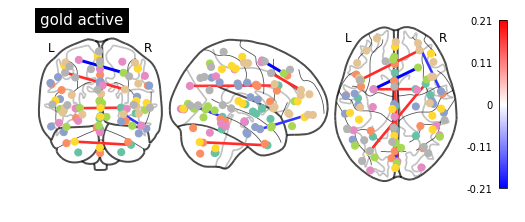

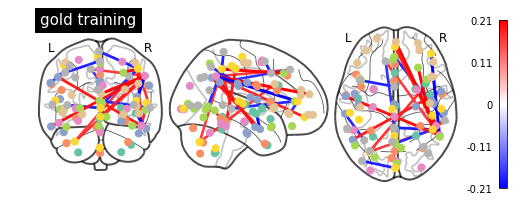

In [11]:
Features_names = ['gold active','gold training']
for i in range(0,2):
    plot_connectome(connectome_matrix(X,Y,i,0.05/4278),coords_connectome,colorbar=True,title=Features_names[i])

Now we're gonna use a K-best selection sklearn method to find the most relevant features.
Since the method only works with one score we'll need to apply it to all the scores and then pick the common features meaning the intersection.

The following function returns the common columns between two matrices, and the indices of those columns in the matrix.

In [12]:
def intersec(A,B):
    L=[]
    index = []
    for j in range(A.shape[1]):
        p = A.T[j]
        for k in B.T:
            if (k==p).all():
                L.append(p)
                index.append(j)
    return np.array(L).T,index

the next function is going to select the K best for both scores and return the feature intersection for them and the indices of features kept after the intersection

In [13]:
def createXkbest(X,Y,K):
    S = SelectKBest(f_regression,k=K)
    X_kbest1 = S.fit_transform(X,Y[:,1])
    Feat_indices = np.sort(S.scores_.argsort()[-K:][::-1])
    X_kbest2 = SelectKBest(f_regression,k=K).fit_transform(X,Y[:,0])
    X_kbestgold, intersec_indices =intersec(X_kbest1,X_kbest2)
    
    return X_kbestgold, Feat_indices[intersec_indices]

The corrsPerFeature function returns the correlations and p-values for all six scores for a PLSR that is fitted with a feature vector obtained after the K selection, it also return the PLSR object, and errors mae and mse.

In [18]:
lpGo = LeavePGroupsOut(n_groups=18)
A = lpGo.split(X,Y,groups_bysubject)

In [25]:
def corrsPerFeature(X,Y,K = 500):

    true_values=[]
    predictions=[]
    corrs=[]
    #using the leave N group out for cross validation
    lpGo = LeavePGroupsOut(n_groups=18) #10% of the dataset
    predicted_Y_ =[]
    true_Y_=[]
    done = 0
    for train_index, test_index in lpGo.split(X,Y,groups_bysubject):
        
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        X_train,feat_indices = createXkbest(X_train,Y_train,K)
    
        plsr = PLSRegression(n_components= min(10,X_train.shape[1]))
        plsr.fit(X_train,Y_train)
        y_pred_= plsr.predict(X_test.T[feat_indices].T)
    
        true_Y_.append(Y_test)
        predicted_Y_.append(y_pred_)
        
        done = 1 
    
        if done == 1:
            break

    for j in range(0,2):
        Fj = []  #true values for feature j
        FjP = [] #predicted values for feature j
        for i in range(0,len(true_Y_[0])):
            Fj.append(true_Y_[0][i][j])
            FjP.append(predicted_Y_[0][i][j])
        corrs.append(pearsonr(Fj,FjP)) #pearson correlation between the true and predicted values
        true_values.append(Fj)
        predictions.append(FjP)
        
    
    mae_gold=(mean_absolute_error(predictions[0],true_values[0]),mean_absolute_error(predictions[1],true_values[1]))
    mse_gold=(mean_squared_error(predictions[0],true_values[0]),mean_squared_error(predictions[1],true_values[1]))
    
    return corrs,plsr,mse_gold,mae_gold,X

In [26]:
#The three follwing loop print the R² and p-value for different values of K so that we ca empirically choose a suitable one
#The first one is for the gold scores, second for imis scores and the last for the combined scores.
for i in range(30,450,15):
    try:
        A = corrsPerFeature(X,Y,i)[0]
        print(A[0][0],A[1][0],i)
    except ValueError:
        pass


0.08305452510416739 -0.10813343402703106 30
0.08305452510416739 -0.10813343402703106 45
0.17676050704219895 0.30960028755686325 60
0.17676050704219895 0.30960028755686325 75
0.2195449724685895 0.3480873468984927 90
0.1753723532434483 0.2567704507324966 105
0.12381902378080589 0.28474856872554594 120
0.11974078844108767 0.27030161441425066 135
0.03905375706000351 0.23276528250129142 150
0.049934146389775884 0.2379882430857379 165
0.09800527249159835 0.2360326202709535 180
0.10884236908978771 0.29923723396014484 195
0.10468654804082236 0.3065208297662548 210
0.09399106877862701 0.2694434475200026 225
0.06049286206758036 0.2055058405005082 240
0.06345007990201963 0.16807133356371406 255
0.18059369888508017 0.14669401981698701 270
0.1766119068146674 0.15800070021662657 285
0.18396536872836514 0.18403992835137714 300
0.2229703929070135 0.13702658407423393 315
0.22838347389188846 0.13181756132842928 330
0.08201857451477919 0.11991890077951547 345
0.07965451893259862 0.04409124407513835 360
0

Now we get to save the PLSR and values that correspond the empirically best results and we'll calculate the mean absolute and the mean squared errors for the predictions and plot the histogram for the true values. 

In [42]:
Cgold,plsr_gold,mse,mae,X2_kbestgold = corrsPerFeature(X,Y,85)

In [43]:
Cgold

[(0.2195449724685895, 0.06582749257868085),
 (0.3480873468984927, 0.002933707339135352)]

In [44]:
for i in range(0,2):
    print(Features_names[i]+': Mean absolute error:'+str(mae[i])+'. Mean squared error:'+str(mse[i]))

gold active: Mean absolute error:7.00093391147404. Mean squared error:70.88768085426074
gold training: Mean absolute error:9.562617918580433. Mean squared error:107.57264189156525
